In [1]:
import os,sys
sys.path.append('./misc/lib/python3.7/site-packages')

import numpy as np
import requests
import nglview as nv
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
import parmed as pmd
import re

import hublib.use
from hublib.ui import FileUpload, Download
from hublib.cmd import runCommand

%use gromacs-5.1.4

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)


<IPython.core.display.Javascript object>

In [2]:

def fix_missing_atoms(mdstruc, resnumber):
    for r in mdstruc.residues:
        if(r.number==resnumber):
            foundC = False
            foundO = False
            foundN = False
            foundCA = False
            for at in r:    
                if at.name=='C':
                    foundC = True
                elif at.name=='O':
                    foundO = True
                elif at.name=='N':
                    foundN = True
                elif at.name=='CA':
                    foundCA = True
                
            if foundC * foundN * foundO * foundCA:
                print('Replacing with GLY')
                mdstruc.strip('(:'+str(r.idx+1)+')&!(@C,CA,N,O)')
                mdstruc.residues[r.idx].name = 'GLY'
            else:
                print('Eliminating from the structure.')
                mdstruc.strip(':'+str(resnumber))
            break

def run_pdb2gmx(mdstruc, fname, lastPass):
    
    bondmax = 1.5*2
    
    success = True
    MissingAtomRegEx = re.compile('.*Residue(.*)named(.*)of a molecule in the input file was mapped to an entry in the topology database, but the atom(.*)used in that entry is not found in the input file')
    ResMisMatchRegEx = re.compile('.*Atom(.*)in residue[ ]+([a-zA-Z]+)[ ]+([0-9]+)[ ]+was not found in rtp entry(.*)with(.*)atoms while sorting atoms')
    ResNotFoundRegEx = re.compile('.*Residue(.*)not found in residue topology database')
    #out=!{"cd gmx; cp gmx/input.pdb.19 gmx/input.pdb; export GMX_MAXBACKUP=-1; gmx pdb2gmx -f input.pdb -o input.gro -ignh -water spce <<EOF\n8\nEOF"}
    out=!{"cd gmx; rm input.gro; export GMX_MAXBACKUP=-1; gmx pdb2gmx -f "+fname+" -o input.gro -ignh -water spce <<EOF\n8\nEOF"}
    msg = ''
    
    madeTop = False
    MadeTopRegEx = re.compile('You have successfully generated a topology')
    for line in out:
        if re.match(MadeTopRegEx, line):
            madeTop = True
    
    WarnNonSeqChain = re.compile('.*Chain identifier \'(.*)\' is used in two non-sequential blocks.*')
    WarnOccup = re.compile('.*there were (.*) atoms with zero occupancy and (.*) atoms.*')
    #WarnLongBond = re.compile('.*Long bond ((.*)-(.*) = (.*) nm).*')
    WarnLongBond = re.compile('.*Long Bond.*\(([0-9]+)-([0-9]+).*\).*')
    WarnAtomMissing = re.compile('.*atom (.*) is missing in residue ([a-zA-Z]+)[ ]+([0-9]+) in the pdb file.*')

    
    for line in out:
        if(success and re.search('warning', line, flags=re.IGNORECASE)):
            if re.match(WarnAtomMissing, line):
                hit = re.match(WarnAtomMissing, line)
                resname = hit.group(2).strip()
                resnumber = int(hit.group(3).strip())
                print('Atoms were missing from residue '+resname+ ' ' + str(resnumber))
                fix_missing_atoms(mdstruc, resnumber)
                mdstruc.write_pdb('gmx/'+fname)
                success = False
            elif re.match(WarnLongBond, line):
                if madeTop:
                    hit = re.match(WarnLongBond, line)
                    at1 = int(hit.group(1))
                    at2 = int(hit.group(2))
                    
                    grostruc = pmd.load_file('gmx/input.gro')
                    x1 = grostruc.coordinates[at1-1]
                    x2 = grostruc.coordinates[at2-1]
                    dist = np.linalg.norm(x1 - x2)
                    
                    # If this is an amide bond, and the distance is unreasonably large, insert a 
                    # chain break between the residues.
                    if (dist>bondmax) and (grostruc[at1-1].name=='C') and (grostruc[at1-1].name=='N'):
                        res1 = grostruc[at1-1].residue.number
                        res2 = grostruc[at2-1].residue.number
                        print('Bond between atoms ' + str(at1) + ' and ' + str(at2) + ' was too long (' + str(dist) +').')
                        print('Identified atoms as belonging to residues ' + str(res1) + ' and ' + str(res2))
                        print('Inserting chain break between them.')
                        if res1<res2:
                            grostruc[at1-1].residue.ter = True
                        else:
                            grostruc[at2-1].residue.ter = True
                        grostruc.write_pdb('gmx/'+fname)
                        success = False
            elif re.match(WarnNonSeqChain, line):
                if lastPass:
                    print('Non-sequential chain warning')
            elif re.match(WarnOccup, line):
                if lastPass:
                    print('Occupancy warning')
            else:
                if lastPass:
                    print(line)
                    print('We are here')
    
    if success: 
        for line in out:
            
            if re.search('error', line, flags=re.IGNORECASE) and (len(msg)==0):
                success = False
                msg = line
                
            elif len(msg)>0:
                if len(line.strip())>0:
                    msg = msg + line + " "
                else:
                    if re.match(MissingAtomRegEx, msg):
                        hit = re.match(MissingAtomRegEx, msg)
                        resnumber = int(hit.group(1))
                        resname = hit.group(2).strip()
                        print('Atoms were missing from residue '+resname+ ' ' + str(resnumber))
                        fix_missing_atoms(mdstruc, resnumber)
                        mdstruc.write_pdb('gmx/'+fname)

                    elif re.match(ResNotFoundRegEx, msg):
                        hit = re.match(ResNotFoundRegEx, msg)
                        resname = hit.group(1).strip().strip('\'')
                        print('Residue '+resname+ ' not available in the force field database.')
                        print('Eliminating from the structure.')
                        mdstruc.strip(':'+resname)
                        mdstruc.write_pdb('gmx/'+fname)

                    elif re.match(ResMisMatchRegEx, msg):
                        hit = re.match(ResMisMatchRegEx, msg)
                        resname = hit.group(2).strip()
                        resnum = int(hit.group(3).strip())
                        print('Residue ' +resname+ ' ' + str(resnum) + ' did not match the force field database entry.')
                        print('Eliminating from the structure.')
                        mdstruc.strip(":"+str(resnum))
                        mdstruc.write_pdb('gmx/'+fname)
                    else:
                        if lastPass:
                            print(msg)

                    msg = ''
    return success
    
def mdgo_onclick(b):
    
    
    chainList = list()
    for r in struc.residues:
        if chainList.count(r.chain)==0:
            chainList.extend(r.chain)
            
    # First identify which chains should be displayed
    chainList = []
    # Loop through chain-selection check-boxes
    for cb in accordion.children[0].children[1:]:
        if cb.value==True:
            chainList.extend(cb.description)
    
    failed = False
    for chain in chainList:
        fname = 'input_'+ chain + '.pdb'
        struc.write_pdb('gmx/'+fname)
        mdstruc = pmd.load_file('gmx/'+fname)
        print("")
        print("********************************************")
        print('Preparing chain ' + str(chain) + ' for MD...')
        print("")
        mdstruc[chain,:,:].write_pdb('gmx/'+fname)
        maxTries = 100
        tries = 0
        tryAgain = True
        while tryAgain:
            tries += 1
            mdstruc = pmd.load_file('gmx/'+fname)
            mdstruc.write_pdb('gmx/' + fname + '.' + str(tries))
            if(run_pdb2gmx(mdstruc, fname, False)):
                tryAgain = False
                run_pdb2gmx(mdstruc, fname, True)
                print('Success!')
                
            elif tries >= maxTries:
                tryAgain = False
                print('Failed to generate gmx input in ' + str(maxTries) + ' attempts')
                failed = True
        if failed:
            break

            

class ExcStruc:
    def __init__(self):
        self.nres = 0
        self.resnums = []
        self.restypes = []
        self.chains = []
        self.ham = []
        self.dips = []
        self.cents = []
        self.couplings = []
        self.struc = pmd.structure.Structure()
            
    def reset(self):
        self.nres = 0
        self.resnums = []
        self.restypes = []
        self.chains = []
        self.ham = []
        self.dips = []
        self.cents = []
        self.struc = pmd.structure.Structure()
        
    def build_structure(self):
        coords = []
        for n in range(0, self.nres):
            cent = xstruc.cents[n,:]
            dip = xstruc.dips[n,:]
            vStart = cent - 1.25*dip
            vStop = cent + 1.25*dip
            
            Nats = 10
            for a in range(0, Nats+1):
                xyz = (a/Nats)*vStart + (1 - a/Nats)*vStop
                self.struc.add_atom(pmd.topologyobjects.Atom(name='N'), 'Dip', self.resnums[n], chain=self.chains[n])
                coords.append(xyz)
        if len(coords)>0:
            self.struc.coordinates = np.array(coords)
            

class NGLRepList:
    def __init__(self):
        self.component_id = ''
        self.params = []
        self.names = []
        self.reps = list()
        
    def reset(self):
        self.component_id = ''
        self.params = []
        self.names = []
        self.reps = list()
        
    def append(self, nrep):
        self.names.append(nrep.name)
        ptext = {"type": nrep.type, "params": {"color": nrep.color, "sele": nrep.selection, "opacity": str(nrep.opacity)}}
        self.params.append(ptext)
        self.reps.append(nrep)
        
class NGLRep:
    def __init__(self, name, rtype, sel, col, opac):
        self.name = name
        self.type = rtype
        self.selection = sel
        self.color = col
        self.opacity = opac

def check_atoms(RefChlA_AtNames, QuerChlA_AtNames):
    ismatch = True
    for atnm in RefChlA_AtNames:
        if(QuerChlA_AtNames.count(atnm)!=1):
            ismatch = False
    return ismatch

def find_porph(pmdstruc, xtruc):
    PORatList = list(['NA', 'NB', 'NC', 'ND'])
    for n in range(0, len(pmdstruc.residues)):
        r = pmdstruc.residues[n]
        nmlist = list()
        for at in r:
            nmlist.append(at.name)
        if(check_atoms(PORatList, nmlist)):
            if(nmlist.count('MG')==1):
                xstruc.resnums.append(n)
                xstruc.nres += 1 
                xstruc.restypes.append('CHL')
                
            else:
                xstruc.resnums.append(n)
                xstruc.nres += 1 
                xstruc.restypes.append('PHO')
            xstruc.chains.append(r.chain)

    return


def find_dipoles(struc,xtruc):
    ResNums = xtruc.resnums
    DipMat = np.zeros((len(ResNums),3))
    for n in range(0, len(ResNums)):
        r = struc.residues[ResNums[n]]
        for at in r:
            if at.name=='NB':
                NB = struc.coordinates[at.idx]
            if at.name=='ND':
                ND = struc.coordinates[at.idx]
        DipMat[n,:] = NB - ND
    xtruc.dips = DipMat

def find_centers(struc, xtruc):
    ResNums = xtruc.resnums
    CentMat = np.zeros((len(ResNums),3))
    for n in range(0, len(ResNums)):
        r = struc.residues[ResNums[n]]
        cent = 0.0
        for at in r:
            if at.name=='NB':
                cent += 0.5*struc.coordinates[at.idx]
            if at.name=='ND':
                cent += 0.5*struc.coordinates[at.idx]
        CentMat[n,:] = cent
    xtruc.cents = CentMat

def sync_widgets_to_rep(rep):
    seldrop.value = rep.name
    styledrop.value = rep.type
    colordrop.value = rep.color
    opacslide.value = int(rep.opacity*100)
    
def sync_rep_to_widgets():
    global repList
    num = repList.names.index(seldrop.value)
    rep = repList.reps[num]
    rep.type = styledrop.value
    rep.name = seldrop.value
    rep.color = colordrop.value
    rep.opacity = opacslide.value*0.01
    ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
    repList.params[num] = ptext
    pdbview.set_representations(repList.params)
    

def std_rep(nglview, struc, xstruc):
    global repList
    pdbview.add_trajectory(struc)
    pdbview.clear(0)
    chltxt = ''
    photxt = ''
    for n in range(0, len(xstruc.resnums)):
        if xstruc.restypes[n]=='CHL':
            if len(chltxt)>0:
                chltxt += ' or '
            chltxt += str(xstruc.resnums[n]+1)
        if xstruc.restypes[n]=='PHO':
            if len(photxt)>0:
                photxt += ' or '
            photxt += str(xstruc.resnums[n]+1)
            
    chainList = list()
    chainString = ''
    for r in struc.residues:
        if chainList.count(r.chain)==0:
            chainList.extend(r.chain)
            if len(chainString)>0:
                chainString += " OR "
            chainString += ":" + r.chain
    
    repList.append(NGLRep("Protein", "cartoon", "(protein)" + "AND (" + chainString + ")", "grey", 0.2))
    if len(chltxt)>0:
        repList.append(NGLRep("Chlorophyll", "licorice", "(" + chltxt + ")" + "AND (" + chainString + ")", "green", 1.0))
    if len(photxt)>0:
        repList.append(NGLRep("Pheophytin", "licorice", "(" + photxt + ")" + "AND (" + chainString + ")", "blue", 1.0))
    
    pdbview.set_representations(repList.params)
    
    seldrop.options=repList.names
    seldrop.disabled=False
    
    styledrop.disabled=False
    
    colordrop.disabled=False
    opacslide.disabled=False
    sync_widgets_to_rep(repList.reps[0])
    
    if xstruc.nres>0:
        pdbview.add_trajectory(xstruc.struc)
        pdbview.set_representations([{"type": "licorice", "params": {"color": "red", "sele": "("+chainString+")", "opacity": "1", "radius": "0.35"}}], component=1)
    
pdbid = widgets.Text(
    value='3EOJ',
    placeholder='Type something',
    layout = widgets.Layout(width='2.5cm'),
    disabled=False
)

pdbidtxt = widgets.Label(value='Enter PDB ID:', width='4cm')

pdbgo = widgets.Button(
    description='Fetch',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to display the pdb file',
    layout = widgets.Layout(width='2cm'),
    icon='' # (FontAwesome names without the `fa-` prefix)
)

pdbup = hublib.ui.FileUpload("", "Upload a PDB file for display and processing", basic=True, width='2cm')

pdboutput = widgets.HTML(
    value="",
    placeholder='',
    description='',
)

Output = widgets.Output()


tresp_go = widgets.Button(
    description='TrESP',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to calculate inter-site couplings using the Transition Electrostatic Potential (TrESP) method',
    layout = widgets.Layout(width='2cm'),
    icon='' # (FontAwesome names without the `fa-` prefix)
)

def tresp_onclick(b):
    
    global xstruc
    
    print('Note: All porphyrrins are currently assumed to be Chlorophyll a')
    #print('Note: All porphyrrins containing MG are currently assumed to be Chlorophyll a')
    #print('All porphyrrins NOT containing MG are currently assumed to be Pheophytin a')
    ChlA_AtNames = ['MG', 'CHA', 'CHB', 'CHC', 'CHD', 'NA', 'C1A', 'C2A', 'C3A', 'C4A', 'CMA', 'CAA', 'CBA', 'CGA', 'O1A', 'O2A', 'NB', 'C1B', 'C2B', 'C3B', 'C4B', 'CMB', 'CAB', 'CBB', 'NC', 'C1C', 'C2C', 'C3C', 'C4C', 'CMC', 'CAC', 'CBC', 'ND', 'C1D', 'C2D', 'C3D', 'C4D', 'CMD', 'CAD', 'OBD', 'CBD', 'CGD', 'O1D', 'O2D', 'CED', 'C1']
    ChlA_Q10 = np.array([-21.674,106.779,-48.696,-98.725,72.726,31.683,-130.820,10.048,2.389,77.983,5.556,-1.050,0.735,-8.040,-1.330,7.091,-62.297,81.122,4.777,-9.204,106.271,16.963,10.681,34.947,-12.166,83.646,-7.420,-1.126,-44.008,-5.161,8.020,1.012,108.292,-110.812,-11.981,8.799,-125.044,-25.156,-19.250,-20.044,-11.238,5.979,-5.388,1.811,-5.256,-1.424])
    ChlA_Q10 = ChlA_Q10*1e-3*4.80326e-10 # cgs base units for charge: cm^3/2 g^1/2 s^−1
    
    Natoms = len(ChlA_AtNames)
    Nporph = xstruc.nres
    AtomPos = np.zeros((Nporph, Natoms, 3))
    AtomQ = np.zeros((Nporph, Natoms, 1))
    CoupMat = np.zeros((Nporph,Nporph))
    h = 6.62607015e-34 #J*s
    c = 2.998e10 #cm/s
    
    err = False
    for n in range(0,Nporph):
        resnum = xstruc.resnums[n]
        tstruc = struc[':'+str(resnum+1)]
        dip = np.zeros((3,))
        for at in range(0,Natoms):
            name = ChlA_AtNames[at] #ChlA_AtNames is a matrix with all the atoms name; (at)th name on the matrix 
            atstruc = tstruc['@'+name]
            if len(atstruc.coordinates)>0:
                AtomPos[n, at, :] = (atstruc.coordinates[0])*(1e-8) # cm
                AtomQ[n,at] = ChlA_Q10[at] # cm^3/2 g^1/2 s^−1
                dip += AtomPos[n,at,:]*AtomQ[n,at]
            else:
                print("Error! Chl " + str(resnum) + ' was incomplete.')
                print("Could not find atom with name " + name)
                err = True
        if (err==False) and (np.linalg.norm(dip)>0):
            AtomQ[n,:] *= (4.3e-18)/np.linalg.norm(dip)
    
    if err==False:
        for m in range (0,Nporph):
            for n in range(0,m):
                for atm in range (0, Natoms): 
                    for atn in range(0, Natoms):
                        Rmn = AtomPos[m,atm,:] - AtomPos[n,atn,:] 
                        rmn = np.linalg.norm(Rmn) 
                        CoupMat[m,n]+= (((AtomQ[m,atm]*AtomQ[n,atn])/(rmn))*(1e-7))/(h*c)

        CoupMat = CoupMat + np.transpose(CoupMat)
        xstruc.couplings = CoupMat

tresp_go.on_click(tresp_onclick)

def pdbwrite_onclick(b):
    fname = "pdb/" + accordion.children[1].children[0].children[0].value
    # First identify which chains should be displayed
    # Loop through chain-selection check-boxes
    strucList = []
    for cb in accordion.children[0].children[1:]:
        if cb.value==True:
            strucList.append(struc[cb.description,:,:])
    
    selstruc = []
    if len(strucList)>0:
        selstruc = strucList[0]
        for n in range(1, len(strucList)):
            selstruc = selstruc + strucList[n]
        selstruc.write_pdb(fname)
        


def clear_stage(view, xstruc):

    view._clear_component_auto_completion()
    if view._trajlist:
        for traj in view._trajlist:
            view._trajlist.remove(traj)
    for component_id in view._ngl_component_ids:
        component_index = view._ngl_component_ids.index(component_id)
        view._ngl_component_ids.remove(component_id)
        view._ngl_component_names.pop(component_index)
        view._remote_call('removeComponent',
            target='Stage',
            args=[component_index,])
    view._update_component_auto_completion()


def pdbup_onclick(widg, fname):
    load_structure(fname[-1])
    widg.reset()
        
def pdbgo_onclick(b):
    fname = 'pdb/' + pdbid.value + '.pdb'
    load_structure(fname)
    
def load_structure(fname):
    global struc
    global estruc
    
    if os.path.isfile(fname):
        fid = fname.split('/')[-1]
        fid = fid.split('.')[0]
        pdbid.value=fid
        
    else:
        url = 'http://files.rcsb.org/download/'+pdbid.value+'.pdb'
        r = requests.get(url, allow_redirects=True)
        if(r.status_code==200):
            fname = 'pdb/'+pdbid.value+'.pdb'
            wfd = open(fname, 'wb')
            wfd.write(r.content)
            wfd.close()
            pdboutput.value = ''
            
        else:
            print('Invalid PDB code. Please try again.')
            
    
        
    if os.path.isfile(fname):
        #clear_stage(pdbview, xstruc)
        while len(pdbview._ngl_component_ids)>0:
            pdbview.remove_component(pdbview._ngl_component_ids[0])
        
        accordion.children = []
        repList.reset()
        xstruc.reset()
        
        struc = pmd.load_file(fname)
        find_porph(struc, xstruc)
        find_dipoles(struc, xstruc)
        find_centers(struc, xstruc)
        xstruc.build_structure()
        std_rep(pdbview, struc, xstruc)
        chainList = list()
        chainString = ''
        for r in struc.residues:
            if chainList.count(r.chain)==0:
                chainList.extend(r.chain)
                chainString += r.chain
                
        chwidgList = [widgets.HBox([widgets.Button(description='All',tooltip='Click to select all chains', layout = widgets.Layout(width='1.5cm')),
                    widgets.Button(description='None',tooltip='Click to deselect all chains',layout = widgets.Layout(width='1.5cm'),)])]
        
        chwidgList[0].children[0].on_click(select_all_chains)
        chwidgList[0].children[1].on_click(deselect_all_chains)
        
        for chain in chainList:
            chwidgList.append(widgets.Checkbox(description=chain, value=True,indent=False))
            chwidgList[-1].observe(chain_box_on_change)
        accordion.children = [widgets.VBox(chwidgList)]
        
        deffnm = pdbid.value + '_' + chainString + '.pdb'
        pdbwrwidglist = [widgets.HBox([widgets.Text(value=deffnm, description='File Name:', disabled=False, layout=widgets.Layout(width='5cm')),widgets.Button(description='Write',tooltip='Click to write PDB file',layout=widgets.Layout(width='1.5cm'),)])]
        pdbwrwidglist[0].children[1].on_click(pdbwrite_onclick)
        
        accordion.children = tuple(list(accordion.children) + [widgets.VBox(pdbwrwidglist)])
        
        accordion.children = tuple(list(accordion.children) + [widgets.VBox([tresp_go])])
        
        mdgo = widgets.Button(
            description='Prepare MD',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click to prepare structure for molecular dynamics (MD)',
            icon='' # (FontAwesome names without the `fa-` prefix)
        )

        mdgolist = [widgets.HBox([mdgo])]
        accordion.children = tuple(list(accordion.children) + [widgets.VBox(mdgolist)])
        accordion.children[3].children[0].children[0].on_click(mdgo_onclick)
        

    else:
        pdboutput.value = 'Please enter a valide PDB ID code.'

def select_all_chains(b):
    for cb in accordion.children[0].children[1:]:
        cb.value = True
        
def deselect_all_chains(b):
    for cb in accordion.children[0].children[1:]:
        cb.value = False
        
        
def chain_box_on_change(b):
    global repList
    if b['type'] == 'change' and b['name'] == 'value':
        
        # First identify which chains should be displayed
        chainString = ''
        chainList = []
        chainChars = ''
        # Loop through chain-selection check-boxes
        for cb in accordion.children[0].children[1:]:
            if cb.value==True:
                chainList.extend(cb.description)
                if len(chainString)>0:
                    chainString += " OR "
                chainString += ":" + cb.description
                chainChars += cb.description
                
        for num in range(0, len(repList.reps)):
            rep = repList.reps[num]
            selList = rep.selection.split('AND')
            selText = ''
            for item in selList:
                if item.find(":")==-1:
                    if len(selText)>0:
                        selText += " AND "
                    selText += item.strip()
            
            if len(chainString)>0:
                selText += " AND (" + chainString + ")"
            else:
                # We assume no structure has chain ID XXXX...
                selText += " AND (:XXXX)"
                
            rep.selection = selText
            ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
            repList.params[num] = ptext
        pdbview.set_representations(repList.params)
        
        if len(chainString)>0:
            pdbview.set_representations([{"type": "licorice", "params": {"color": "red", "sele": "("+chainString+")", "opacity": "1", "radius": "0.35"}}], component=1)
            accordion.children[1].children[0].children[0].value = pdbid.value + "_" + chainChars + '.pdb'
            accordion.children[1].children[0].children[1].disabled = False
            accordion.children[2].children[0].children[0].disabled = False
        else:
            pdbview.set_representations([{"type": "licorice", "params": {"color": "red", "sele": "(:XXXX)", "opacity": "1", "radius": "0.35"}}], component=1)
            accordion.children[1].children[0].children[0].value = ''
            accordion.children[1].children[0].children[1].disabled = True
            accordion.children[2].children[0].children[0].disabled = True
            
                
    
def seldrop_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        rep = repList.reps[repList.names.index(seldrop.value)]
        sync_widgets_to_rep(rep)
        
def styledrop_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        num = repList.names.index(seldrop.value)
        rep = repList.reps[num]
        rep.type = styledrop.value
        ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
        repList.params[num] = ptext
        pdbview.set_representations(repList.params)
        
def colordrop_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        num = repList.names.index(seldrop.value)
        rep = repList.reps[num]
        rep.color = colordrop.value
        ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
        repList.params[num] = ptext
        pdbview.set_representations(repList.params)
        
def opacslide_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        num = repList.names.index(seldrop.value)
        rep = repList.reps[num]
        rep.opacity = opacslide.value*0.01
        ptext = {"type": rep.type, "params": {"color": rep.color, "sele": rep.selection, "opacity": str(rep.opacity)}}
        repList.params[num] = ptext
        pdbview.set_representations(repList.params)

xstruc = ExcStruc()
pdbgo.on_click(pdbgo_onclick)
pdbup.cb = pdbup_onclick
pdbid.on_submit(pdbgo_onclick)
pdbview = nv.NGLWidget()
pdbview._set_size('500px', '500px')
repList = NGLRepList()

seldrop = widgets.Dropdown(
    options=repList.names,
    #value='Protein',
    description='Selection:',
    disabled=True,
)

styledrop = widgets.Dropdown(
    options=['cartoon', 'licorice', 'spacefill'],
    description='Style:',
    disabled=True,
)

colordrop = widgets.Dropdown(
    options=['chain', 'red', 'green', 'blue', 'grey'],
    description='Color:',
    disabled=True,
)

opacslide = widgets.IntSlider(
    min=0,
    max=100,
    step=1,
    description='Opacity:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

from ipywidgets import Layout
accordion = widgets.Accordion(children=[])
accordion.set_title(0, 'Chain Selection')
accordion.set_title(1, 'Write PDB')
accordion.set_title(2, 'Calculate Couplings')
accordion.set_title(3, 'Prepare for MD')

#pdbuptext = widgets.Label(value="Or upload a file:", layout=widgets.Layout(width='3.5cm', display="flex", justify_content='flex-end'))

pdbbox = widgets.HBox([pdbidtxt, pdbid, pdbgo])
dispbox = widgets.VBox([seldrop, styledrop, colordrop, opacslide, accordion])
viewbox = widgets.HBox([pdbview, dispbox])

seldrop.observe(seldrop_on_change)
styledrop.observe(styledrop_on_change)
colordrop.observe(colordrop_on_change)
opacslide.observe(opacslide_on_change)

display(pdbbox)
display(pdbup)
display(pdboutput)
display(viewbox)
struc = pmd.structure.Structure()


HTML(value='', placeholder='')

Note: All porphyrrins are currently assumed to be Chlorophyll a


Button(description='Wavenumbers', layout=Layout(width='2cm'), style=ButtonStyle(), tooltip='Generating Spectru…

Button(description='Wavelength', layout=Layout(width='2cm'), style=ButtonStyle(), tooltip='Generating Spectrum…

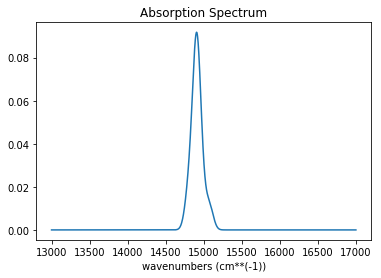

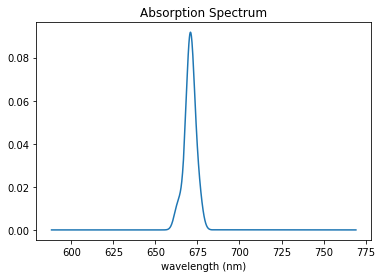

In [19]:
from scipy.ndimage import gaussian_filter

wavenumbers_go = widgets.Button(
    description='Wavenumbers',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Generating Spectrum in Wavenumbers from Coupling Matrix',
    layout = widgets.Layout(width='2cm'),
    icon='' # (FontAwesome names without the `fa-` prefix)
    )

def wavenumbers_onclick(b):
    Nporph = xstruc.nres
    # Set up the frequency axis
    v1 = 13000
    v2 = 17000
    dv = 1
    vaxis = np.arange(v1,v2,dv)
    lamb = (1.0e+7)/vaxis
    spec = np.zeros(np.shape(vaxis))
    Ham = xstruc.couplings + np.eye(Nporph)*14925.37 #16500 is the value we are interested in but we do not know how to calculate yet - NSD calculation (670 nm to wavenumbers)

    # Generate a random ensemble of site energies, diagonalize, and add results to spectrum
    eVals,eVecs = np.linalg.eigh(Ham)
    eMu = np.matmul(np.transpose(eVecs), xstruc.dips)

    for n in range(0,Nporph):
        ndx = np.where(np.abs(vaxis-eVals[n])==np.min(np.abs(vaxis-eVals[n])))[0][0]
        spec[ndx] += np.linalg.norm(eMu[n])**2/Nporph #mu is a 3 element vector
        r = gaussian_filter(spec, sigma=50)
    
    # Plot the spectrum in cm-1
    plt.figure()
    Wavenumbers = plt.plot(vaxis, r)
    plt.xlabel('wavenumbers (cm**(-1))')
    plt.title('Absorption Spectrum')

wavenumbers_go.on_click(wavenumbers_onclick)
display(wavenumbers_go)


wavelength_go = widgets.Button(
    description='Wavelength',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Generating Spectrum in Wavelength from Coupling Matrix',
    layout = widgets.Layout(width='2cm'),
    icon='' # (FontAwesome names without the `fa-` prefix)
    )

def wavelength_onclick(b):
    Nporph = xstruc.nres
    # Set up the frequency axis
    v1 = 13000
    v2 = 17000
    dv = 1
    vaxis = np.arange(v1,v2,dv)
    lamb = (1.0e+7)/vaxis
    spec = np.zeros(np.shape(vaxis))
    Ham = xstruc.couplings + np.eye(Nporph)*14925.37 #16500 is the value we are interested in but we do not know how to calculate yet - NSD calculation (670 nm to wavenumbers)

    # Generate a random ensemble of site energies, diagonalize, and add results to spectrum
    eVals,eVecs = np.linalg.eigh(Ham)
    eMu = np.matmul(np.transpose(eVecs), xstruc.dips)

    for n in range(0,Nporph):
        ndx = np.where(np.abs(vaxis-eVals[n])==np.min(np.abs(vaxis-eVals[n])))[0][0]
        spec[ndx] += np.linalg.norm(eMu[n])**2/Nporph #mu is a 3 element vector
        r = gaussian_filter(spec, sigma=50)

    # Plot the spectrum in nm
    plt.figure()
    Wavelength = plt.plot(lamb,r)
    plt.xlabel('wavelength (nm)')
    plt.title('Absorption Spectrum')
    
wavelength_go.on_click(wavelength_onclick)
display(wavelength_go)